In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import linear_model,preprocessing,metrics
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('./../outputData/ipd_deg_expr.csv' , index_col=0)

In [3]:
def logistic_cross_val(C , X_input , y_output) :
    model = sk.linear_model.LogisticRegression(penalty='l2' , C = C , max_iter=10000)
    kf = sk.model_selection.KFold(n_splits=10)
    mean_error = []
    for train , test in kf.split(X_input) : 
        model.fit(X_input[train] , y_output[train])
        ypred = model.predict(X_input[test])
        mean_error.append(sk.metrics.mean_squared_error(y_output[test] , ypred))

    return np.array(mean_error).mean() , np.array(mean_error).std()

## Classifying Affected vs. Unaffected all time

In [25]:
df.iloc[1:5,-5:]

,ENSG00000273729.1,ENSG00000146112.11,ENSG00000165732.12,meta_df.Clinical_Event,PD_status
2,7.437666,9.997821,11.645366,BL,Unaffected
3,6.998564,10.288158,11.595641,BL,Affected
4,8.277100,12.510490,11.006795,BL,Affected
5,8.117009,11.094668,11.149939,BL,Affected


In [24]:
X = df.iloc[:,1:278]
y = df.iloc[: , -1] 
X_train , X_test , y_train , y_test = sk.model_selection.train_test_split(X , y , test_size = 0.2)

In [5]:
X_train.shape

(1286, 277)

In [6]:
X_test.shape

(322, 277)

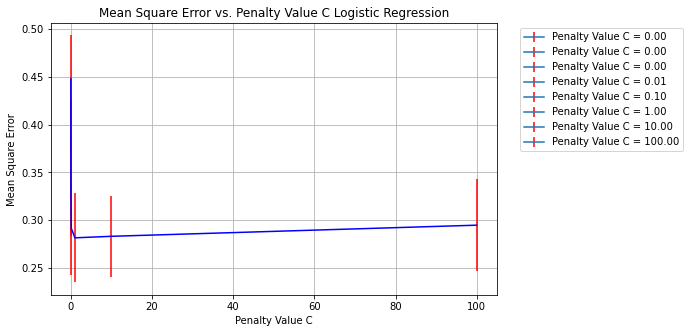

In [42]:
mean_error = []
std_error = []
y_train_float = [(i == 'Affected')*1 for i in y_train]
C_range = [1e-5*(10**i) for i in range(8)] 
for item in C_range : 
    output = logistic_cross_val(item , np.array(X_train) , np.array(y_train_float))
    mean_error.append(output[0])
    std_error.append(output[1])

fig , ax = plt.subplots(figsize = (8,5))
plt.plot(C_range , mean_error, c = 'b')
for i in range(len(C_range)) : 
    ax.errorbar(C_range[i] , mean_error[i] , yerr=std_error[i] , ecolor='r' , label = "Penalty Value C = %1.2f" % C_range[i])
plt.xlabel("Penalty Value C")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error vs. Penalty Value C Logistic Regression")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()

In [25]:
model = sk.linear_model.LogisticRegression(penalty='l2' , C = 0.1 , max_iter=5000).fit(X_train , y_train)
dummy_model = DummyClassifier(strategy='most_frequent').fit(X_train , y_train)

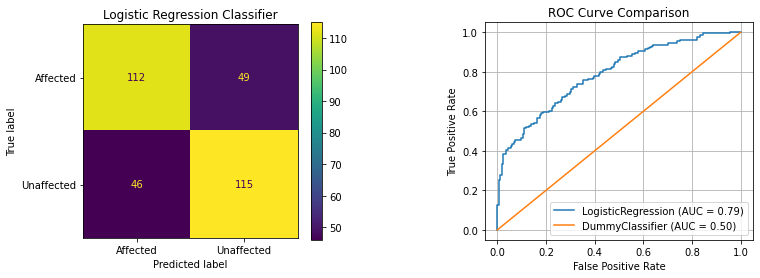

In [26]:
fig , ax = plt.subplots(1,2 , gridspec_kw={'hspace': .1 , 'wspace': .5})
fig.set_figwidth(12)
sk.metrics.plot_confusion_matrix(model , X_test , y_test , ax = ax[0])
sk.metrics.plot_roc_curve(model , X_test , y_test , ax = ax[1])
sk.metrics.plot_roc_curve(dummy_model , X_test , y_test , ax = ax[1])
ax[1].set_title('ROC Curve Comparison')
plt.grid()
ax[0].set_title('Logistic Regression Classifier')
plt.savefig('./../Plots/log_reg_all_iPD.png')

In [27]:
sum((abs(model.coef_) >= 0.1)[0])

163

In [78]:
df2 = pd.DataFrame([X_train.columns , model.coef_[0]]).T

df2['abs'] = abs(df2[1])

df2.sort_values(by = 'abs').iloc[-10: , 0:2].to_csv('./../outputData/iPD_all_ft.csv')
df2

,0,1,abs
0,ENSG00000135378.3,-0.537894,0.537894
1,ENSG00000257878.1,-0.395486,0.395486
2,ENSG00000134321.11,-0.375203,0.375203
3,ENSG00000123610.4,-0.183739,0.183739
4,ENSG00000093134.14,-0.554982,0.554982
...,...,...,...
272,ENSG00000131669.9,0.144784,0.144784
273,ENSG00000171223.5,0.300028,0.300028
274,ENSG00000273729.1,-0.125001,0.125001
275,ENSG00000146112.11,0.038984,0.038984


In [30]:
df2.sort_values(by = 'abs').iloc[-10: , 0:2]

,0,1
29,ENSG00000164674.15,-0.443833
0,ENSG00000135378.3,-0.474181
4,ENSG00000093134.14,-0.485592
112,ENSG00000104549.11,0.489422
135,ENSG00000197249.13,-0.50425
129,ENSG00000128383.12,0.514637
51,ENSG00000135898.9,0.516215
222,ENSG00000070731.10,0.572156
172,ENSG00000140391.14,0.724103
182,ENSG00000080200.9,0.753619


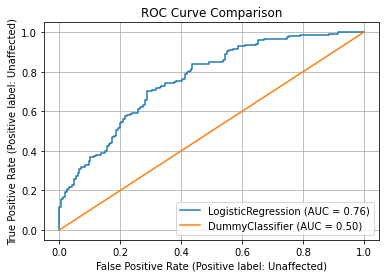

In [36]:
fig , ax = plt.subplots()
sk.metrics.plot_roc_curve(model , X_test , y_test , ax = ax)
sk.metrics.plot_roc_curve(dummy_model , X_test , y_test , ax = ax)
ax.set_title('ROC Curve Comparison')
plt.grid()

In [37]:
print('The test accuracy is %2.2f%%' % (model.score(X_test , y_test)*100))

The test accuracy is 70.50%


## Classifying Affected vs. Unaffected at BL

In [50]:
df_BL = df[df['meta_df.Clinical_Event'] == 'BL']
X = df_BL.iloc[:,1:208]
y = df_BL.iloc[: , -1] 
X_train , X_test , y_train , y_test = sk.model_selection.train_test_split(X , y , test_size = 0.2)

In [51]:
X.shape

(366, 207)

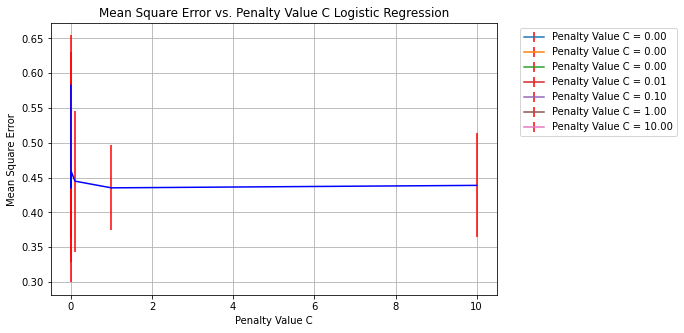

In [39]:
mean_error = []
std_error = []
y_train_float = [(i == 'Affected')*1 for i in y_train]
C_range = [1e-5*(10**i) for i in range(7)] 
for item in C_range : 
    output = logistic_cross_val(item , np.array(X_train) , np.array(y_train_float))
    mean_error.append(output[0])
    std_error.append(output[1])

fig , ax = plt.subplots(figsize = (8,5))
plt.plot(C_range , mean_error, c = 'b')
for i in range(len(C_range)) : 
    ax.errorbar(C_range[i] , mean_error[i] , yerr=std_error[i] , ecolor='r' , label = "Penalty Value C = %1.2f" % C_range[i])
plt.xlabel("Penalty Value C")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error vs. Penalty Value C Logistic Regression")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()

In [41]:
model = sk.linear_model.LogisticRegression(penalty='l2' , C = 1 , max_iter=5000).fit(X_train , y_train)
dummy_model = DummyClassifier(strategy='most_frequent').fit(X_train , y_train)

Text(0.5, 1.0, 'Dummy Classifier')

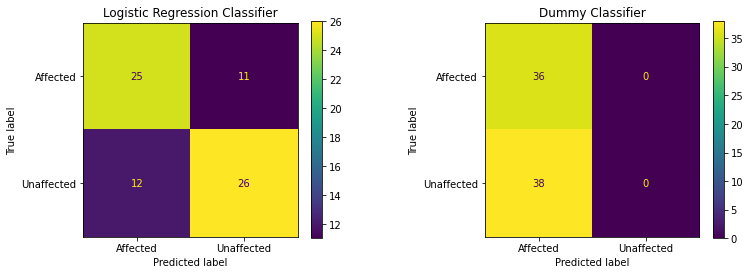

In [42]:
fig , ax = plt.subplots(1,2 , gridspec_kw={'hspace': .1 , 'wspace': .5})
fig.set_figwidth(12)
sk.metrics.plot_confusion_matrix(model , X_test , y_test , ax = ax[0])
sk.metrics.plot_confusion_matrix(dummy_model , X_test , y_test , ax = ax[1])
ax[0].set_title('Logistic Regression Classifier')
ax[1].set_title('Dummy Classifier')

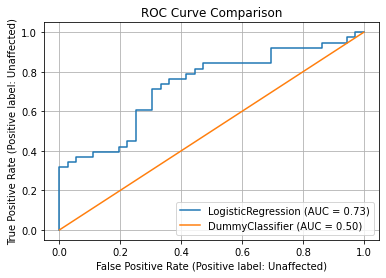

In [43]:
fig , ax = plt.subplots()
sk.metrics.plot_roc_curve(model , X_test , y_test , ax = ax)
sk.metrics.plot_roc_curve(dummy_model , X_test , y_test , ax = ax)
ax.set_title('ROC Curve Comparison')
plt.grid()

In [44]:
print('The test accuracy is %2.2f%%' % (model.score(X_test , y_test)*100))

The test accuracy is 68.92%


## Classifying Affected vs. Unaffected at V02

In [54]:
df_V02 = df[df['meta_df.Clinical_Event'] == 'V02']
X = df_V02.iloc[:,1:208]
y = df_V02.iloc[: , -1] 
X_train , X_test , y_train , y_test = sk.model_selection.train_test_split(X , y , test_size = 0.2)

In [55]:
X.shape

(328, 207)

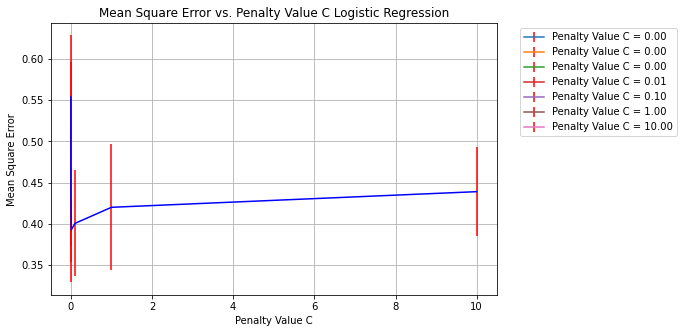

In [46]:
mean_error = []
std_error = []
y_train_float = [(i == 'Affected')*1 for i in y_train]
C_range = [1e-5*(10**i) for i in range(7)] 
for item in C_range : 
    output = logistic_cross_val(item , np.array(X_train) , np.array(y_train_float))
    mean_error.append(output[0])
    std_error.append(output[1])

fig , ax = plt.subplots(figsize = (8,5))
plt.plot(C_range , mean_error, c = 'b')
for i in range(len(C_range)) : 
    ax.errorbar(C_range[i] , mean_error[i] , yerr=std_error[i] , ecolor='r' , label = "Penalty Value C = %1.2f" % C_range[i])
plt.xlabel("Penalty Value C")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error vs. Penalty Value C Logistic Regression")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()

In [47]:
model = sk.linear_model.LogisticRegression(penalty='l2' , C = 0.1 , max_iter=5000).fit(X_train , y_train)
dummy_model = DummyClassifier(strategy='most_frequent').fit(X_train , y_train)

Text(0.5, 1.0, 'Dummy Classifier')

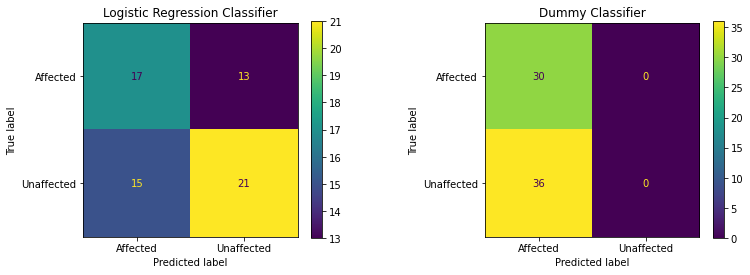

In [48]:
fig , ax = plt.subplots(1,2 , gridspec_kw={'hspace': .1 , 'wspace': .5})
fig.set_figwidth(12)
sk.metrics.plot_confusion_matrix(model , X_test , y_test , ax = ax[0])
sk.metrics.plot_confusion_matrix(dummy_model , X_test , y_test , ax = ax[1])
ax[0].set_title('Logistic Regression Classifier')
ax[1].set_title('Dummy Classifier')

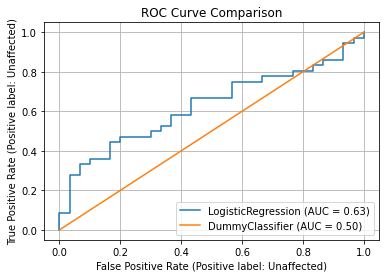

In [49]:
fig , ax = plt.subplots()
sk.metrics.plot_roc_curve(model , X_test , y_test , ax = ax)
sk.metrics.plot_roc_curve(dummy_model , X_test , y_test , ax = ax)
ax.set_title('ROC Curve Comparison')
plt.grid()

In [50]:
print('The test accuracy is %2.2f%%' % (model.score(X_test , y_test)*100))

The test accuracy is 57.58%


## Classifying Affected vs. Unaffected at V04

In [15]:
df_V04 = df[df['meta_df.Clinical_Event'] == 'V04']
X = df_V04.iloc[:,1:278]
y = df_V04.iloc[: , -1] 
X_train , X_test , y_train , y_test = sk.model_selection.train_test_split(X , y , test_size = 0.2)

In [16]:
X_train.shape

(260, 277)

In [17]:
X_test.shape

(65, 277)

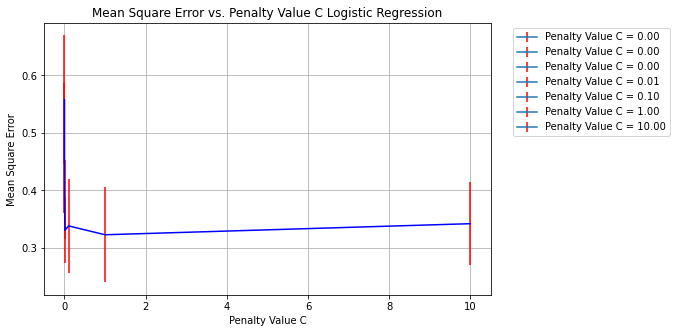

In [32]:
mean_error = []
std_error = []
y_train_float = [(i == 'Affected')*1 for i in y_train]
C_range = [1e-5*(10**i) for i in range(7)] 
for item in C_range : 
    output = logistic_cross_val(item , np.array(X_train) , np.array(y_train_float))
    mean_error.append(output[0])
    std_error.append(output[1])

fig , ax = plt.subplots(figsize = (8,5))
plt.plot(C_range , mean_error, c = 'b')
for i in range(len(C_range)) : 
    ax.errorbar(C_range[i] , mean_error[i] , yerr=std_error[i] , ecolor='r' , label = "Penalty Value C = %1.2f" % C_range[i])
plt.xlabel("Penalty Value C")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error vs. Penalty Value C Logistic Regression")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()

In [70]:
sum(df2['abs'] > 0.1)/278

0.7877697841726619

In [18]:
model = sk.linear_model.LogisticRegression(penalty='l2' , C = 1 , max_iter=5000).fit(X_train , y_train)
dummy_model = DummyClassifier(strategy='most_frequent').fit(X_train , y_train)

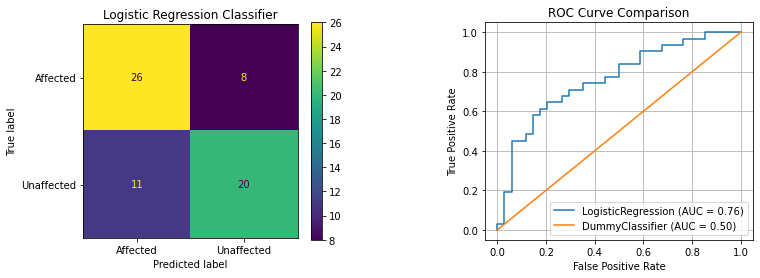

In [19]:
fig , ax = plt.subplots(1,2 , gridspec_kw={'hspace': .1 , 'wspace': .5})
fig.set_figwidth(12)
sk.metrics.plot_confusion_matrix(model , X_test , y_test , ax = ax[0])
sk.metrics.plot_roc_curve(model , X_test , y_test , ax = ax[1])
sk.metrics.plot_roc_curve(dummy_model , X_test , y_test , ax = ax[1])
ax[1].set_title('ROC Curve Comparison')
plt.grid()
ax[0].set_title('Logistic Regression Classifier')
plt.savefig('./../Plots/log_reg_V04_iPD.png')

In [20]:
sum((abs(model.coef_) >= 0.1)[0])

224

In [75]:
df2 = pd.DataFrame([X_train.columns , model.coef_[0]]).T

df2['abs'] = abs(df2[1])

df2.sort_values(by = 'abs').iloc[-10: , 0:2].to_csv('./../outputData/iPD_V04_ft.csv')
df2

,0,1,abs
0,ENSG00000135378.3,-0.972541,0.972541
1,ENSG00000257878.1,-0.140846,0.140846
2,ENSG00000134321.11,-0.366654,0.366654
3,ENSG00000123610.4,-0.301612,0.301612
4,ENSG00000093134.14,-1.153106,1.153106
...,...,...,...
272,ENSG00000131669.9,0.246477,0.246477
273,ENSG00000171223.5,0.497489,0.497489
274,ENSG00000273729.1,0.612249,0.612249
275,ENSG00000146112.11,-0.327184,0.327184


In [36]:
df2.sort_values(by = 'abs').iloc[-10: , 0:2]

,0,1
215,ENSG00000099985.3,0.891721
168,ENSG00000268081.1,-0.909078
4,ENSG00000093134.14,-0.910305
135,ENSG00000197249.13,-0.936691
182,ENSG00000080200.9,0.961788
0,ENSG00000135378.3,-1.024193
93,ENSG00000116991.10,1.038121
188,ENSG00000197852.10,-1.195257
62,ENSG00000167434.9,-1.243466
161,ENSG00000120129.5,-1.335873


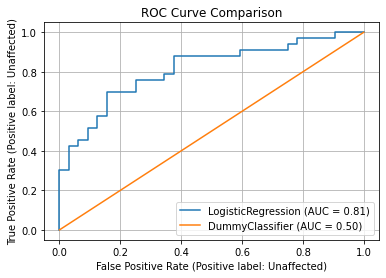

In [55]:
fig , ax = plt.subplots()
sk.metrics.plot_roc_curve(model , X_test , y_test , ax = ax)
sk.metrics.plot_roc_curve(dummy_model , X_test , y_test , ax = ax)
ax.set_title('ROC Curve Comparison')
plt.grid()

In [56]:
print('The test accuracy is %2.2f%%' % (model.score(X_test , y_test)*100))

The test accuracy is 73.85%


## Classifying Affected vs. Unaffected at V06

In [57]:
df_V06 = df[df['meta_df.Clinical_Event'] == 'V06']
X = df_V06.iloc[:,1:208]
y = df_V06.iloc[: , -1] 
X_train , X_test , y_train , y_test = sk.model_selection.train_test_split(X , y , test_size = 0.2)

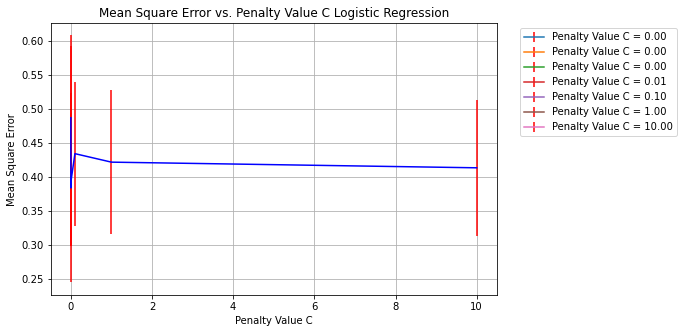

In [58]:
mean_error = []
std_error = []
y_train_float = [(i == 'Affected')*1 for i in y_train]
C_range = [1e-5*(10**i) for i in range(7)] 
for item in C_range : 
    output = logistic_cross_val(item , np.array(X_train) , np.array(y_train_float))
    mean_error.append(output[0])
    std_error.append(output[1])

fig , ax = plt.subplots(figsize = (8,5))
plt.plot(C_range , mean_error, c = 'b')
for i in range(len(C_range)) : 
    ax.errorbar(C_range[i] , mean_error[i] , yerr=std_error[i] , ecolor='r' , label = "Penalty Value C = %1.2f" % C_range[i])
plt.xlabel("Penalty Value C")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error vs. Penalty Value C Logistic Regression")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()

In [59]:
model = sk.linear_model.LogisticRegression(penalty='l2' , C = 1 , max_iter=5000).fit(X_train , y_train)
dummy_model = DummyClassifier(strategy='most_frequent').fit(X_train , y_train)

Text(0.5, 1.0, 'Dummy Classifier')

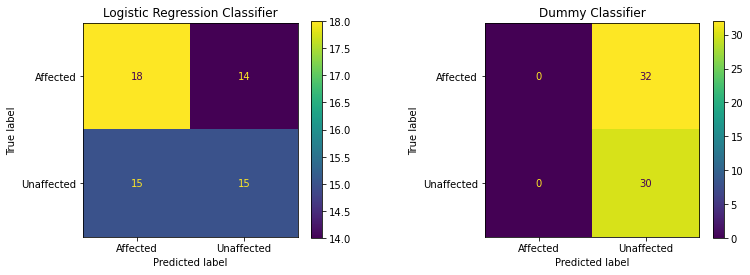

In [60]:
fig , ax = plt.subplots(1,2 , gridspec_kw={'hspace': .1 , 'wspace': .5})
fig.set_figwidth(12)
sk.metrics.plot_confusion_matrix(model , X_test , y_test , ax = ax[0])
sk.metrics.plot_confusion_matrix(dummy_model , X_test , y_test , ax = ax[1])
ax[0].set_title('Logistic Regression Classifier')
ax[1].set_title('Dummy Classifier')

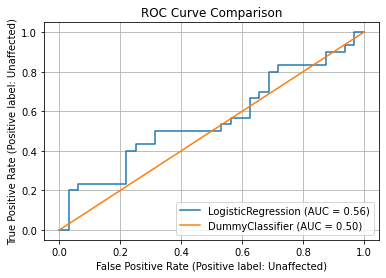

In [61]:
fig , ax = plt.subplots()
sk.metrics.plot_roc_curve(model , X_test , y_test , ax = ax)
sk.metrics.plot_roc_curve(dummy_model , X_test , y_test , ax = ax)
ax.set_title('ROC Curve Comparison')
plt.grid()

In [62]:
print('The test accuracy is %2.2f%%' % (model.score(X_test , y_test)*100))

The test accuracy is 53.23%


## Classifying Affected vs. Unaffected at V08

In [63]:
df_V08 = df[df['meta_df.Clinical_Event'] == 'V08']
X = df_V08.iloc[:,1:208]
y = df_V08.iloc[: , -1] 
X_train , X_test , y_train , y_test = sk.model_selection.train_test_split(X , y , test_size = 0.2)

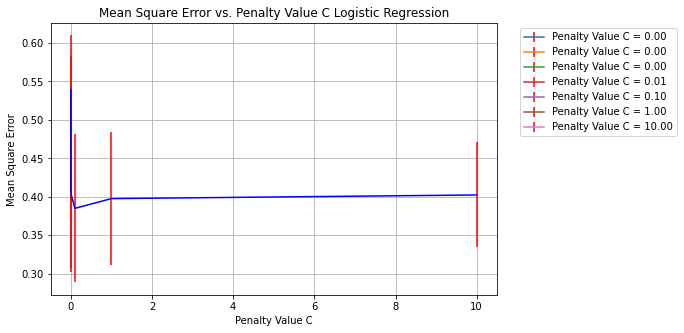

In [64]:
mean_error = []
std_error = []
y_train_float = [(i == 'Affected')*1 for i in y_train]
C_range = [1e-5*(10**i) for i in range(7)] 
for item in C_range : 
    output = logistic_cross_val(item , np.array(X_train) , np.array(y_train_float))
    mean_error.append(output[0])
    std_error.append(output[1])

fig , ax = plt.subplots(figsize = (8,5))
plt.plot(C_range , mean_error, c = 'b')
for i in range(len(C_range)) : 
    ax.errorbar(C_range[i] , mean_error[i] , yerr=std_error[i] , ecolor='r' , label = "Penalty Value C = %1.2f" % C_range[i])
plt.xlabel("Penalty Value C")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error vs. Penalty Value C Logistic Regression")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()

In [65]:
model = sk.linear_model.LogisticRegression(penalty='l2' , C = 0.1 , max_iter=5000).fit(X_train , y_train)
dummy_model = DummyClassifier(strategy='most_frequent').fit(X_train , y_train)

Text(0.5, 1.0, 'Dummy Classifier')

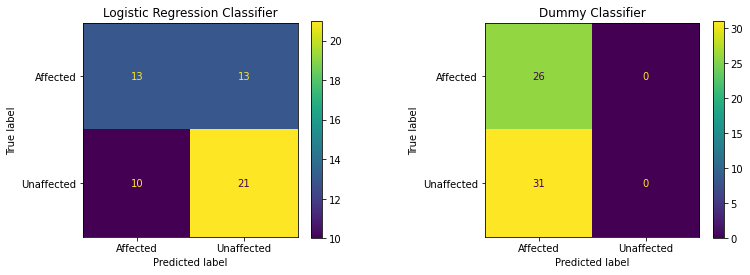

In [66]:
fig , ax = plt.subplots(1,2 , gridspec_kw={'hspace': .1 , 'wspace': .5})
fig.set_figwidth(12)
sk.metrics.plot_confusion_matrix(model , X_test , y_test , ax = ax[0])
sk.metrics.plot_confusion_matrix(dummy_model , X_test , y_test , ax = ax[1])
ax[0].set_title('Logistic Regression Classifier')
ax[1].set_title('Dummy Classifier')

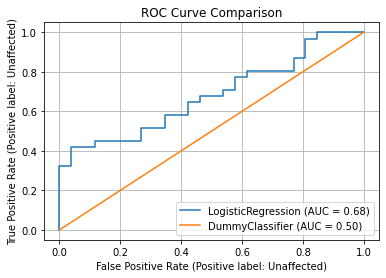

In [67]:
fig , ax = plt.subplots()
sk.metrics.plot_roc_curve(model , X_test , y_test , ax = ax)
sk.metrics.plot_roc_curve(dummy_model , X_test , y_test , ax = ax)
ax.set_title('ROC Curve Comparison')
plt.grid()

In [68]:
print('The test accuracy is %2.2f%%' % (model.score(X_test , y_test)*100))

The test accuracy is 59.65%


## Classifying the Time from which a sample came

In [69]:
from sklearn import svm

X = df.iloc[:,1:208]
y = df.iloc[: , -2] 
X_train , X_test , y_train , y_test = sk.model_selection.train_test_split(X , y , test_size = 0.2)

clf = svm.SVC(decision_function_shape='ovo', C=50)
clf.fit(X_train , y_train)

SVC(C=50, decision_function_shape='ovo')

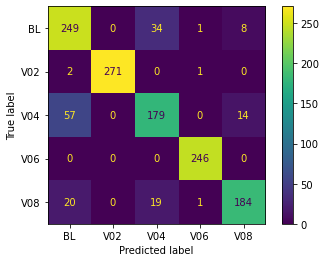

In [70]:
sk.metrics.plot_confusion_matrix(clf , X_train , y_train)

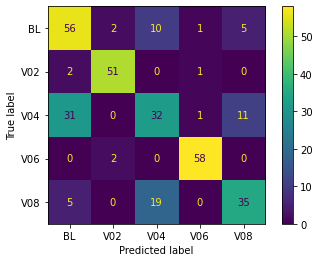

In [71]:
sk.metrics.plot_confusion_matrix(clf , X_test , y_test)